# 🔋 Phase 3: Validasi EKF pada Profil Beban Dinamis (Urban Load)
**Tujuan:** Membuktikan bahwa algoritma Extended Kalman Filter (EKF) mampu memprediksi State of Charge (SoC) dan Tegangan dengan akurat di bawah simulasi beban perumahan yang ekstrem dan acak (15A, 5A, 10A).

**Dataset Input:**
1. `hppc (loop10x).csv` (Untuk R0, R1, C1)
2. `ocv_lookup_table.csv` (Untuk OCV)
3. `Dynamic Profiling (Urban Load).csv` (Data Uji Beban Nyata)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# =========================================================
# FUNGSI BACA CSV ZKETECH (ANTI ERROR)
# =========================================================
def load_zke_data(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

# =========================================================
# 1. PERSIAPAN: LOAD PARAMETER DARI TEST SEBELUMNYA
# =========================================================

# --- A. Load True OCV (Dari File 2) ---
df_ocv = pd.read_csv('ocv_lookup_table.csv')
f_OCV = interp1d(df_ocv['SoC'], df_ocv['True_OCV'], kind='linear', fill_value='extrapolate')

# 🚨 INI DIA KUNCI PERBAIKANNYA (SAFEGUARD LiFePO4) 🚨
def get_dOCV_dSoC(soc):
    delta = 0.001
    slope = (f_OCV(soc + delta) - f_OCV(soc - delta)) / (2 * delta)
    # Paksa kemiringan (slope) agar selalu positif (minimal 0.001)
    # Ini mencegah EKF "nyangkut" di kurva LiFePO4 yang datar/keriting
    return max(0.001, float(slope)) 

# --- B. Ekstrak Cepat R0, R1, C1 (Dari File 1 - HPPC) ---
df_hppc = load_zke_data("hppc (loop10x).csv")

is_pulse = (df_hppc['Cur(A)'] > 9.0) & (df_hppc['Cur(A)'] < 10.5)
pulse_starts = df_hppc.index[is_pulse.astype(int).diff() == 1].tolist()
pulse_ends = df_hppc.index[is_pulse.astype(int).diff() == -1].tolist()

results_rc = []
for i in range(min(len(pulse_starts), len(pulse_ends))):
    start, end = pulse_starts[i], pulse_ends[i]
    OCV = df_hppc.loc[start - 1, 'Vol(V)']
    t_start = df_hppc.loc[start, 'Time(S)']
    t = df_hppc.loc[start:end-1, 'Time(S)'] - t_start
    V = df_hppc.loc[start:end-1, 'Vol(V)']
    
    R0_guess = max((OCV - V.iloc[0]) / 10.0, 0.001)
    def ecm(t, R0, R1, C1): return OCV - 10.0 * R0 - 10.0 * R1 * (1 - np.exp(-t / (R1 * C1)))
    try:
        popt, _ = curve_fit(ecm, t, V, p0=[R0_guess, 0.01, 1000], bounds=(0, [1, 1, 100000]))
        results_rc.append({'SoC': (90 - i*10)/100.0, 'R0': popt[0], 'R1': popt[1], 'C1': popt[2]})
    except: pass

df_rc = pd.DataFrame(results_rc).sort_values(by='SoC')

f_R0 = interp1d(df_rc['SoC'], df_rc['R0'], kind='linear', fill_value='extrapolate')
f_R1 = interp1d(df_rc['SoC'], df_rc['R1'], kind='linear', fill_value='extrapolate')
f_C1 = interp1d(df_rc['SoC'], df_rc['C1'], kind='linear', fill_value='extrapolate')

print("✅ Parameter OCV (Dengan Safeguard), R0, R1, dan C1 berhasil dimuat!") 

✅ Parameter OCV (Dengan Safeguard), R0, R1, dan C1 berhasil dimuat!


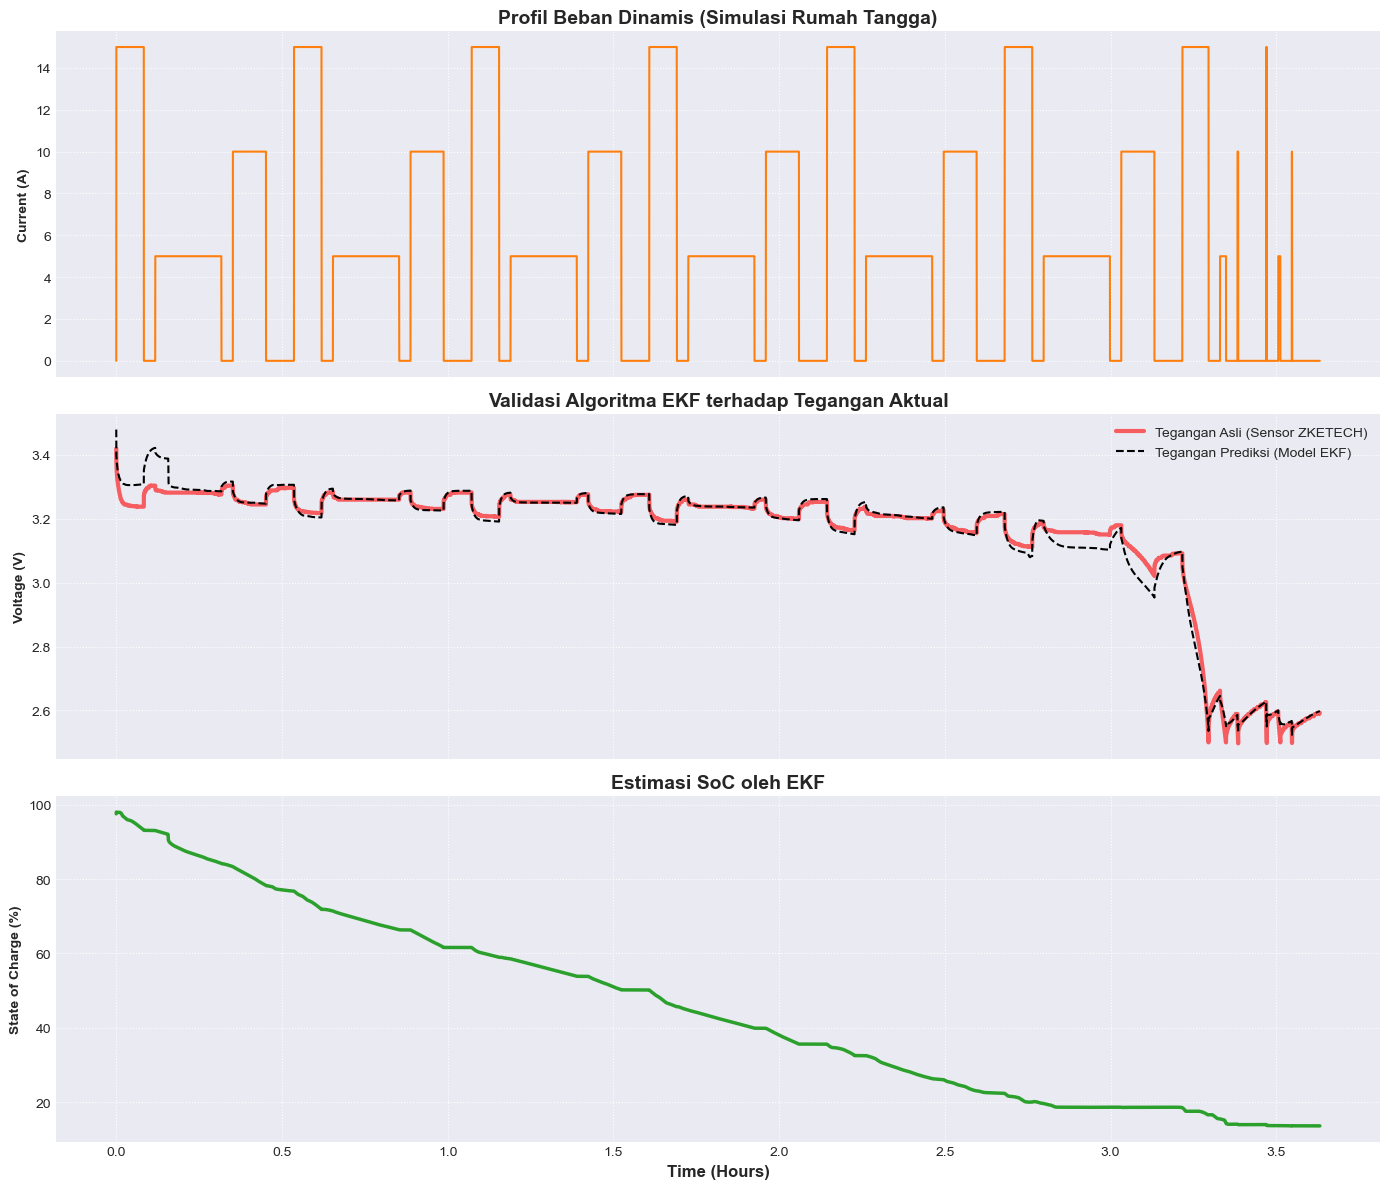

In [2]:
# =========================================================
# 2. ALGORITMA EKF (EXTENDED KALMAN FILTER)
# =========================================================
class BatteryEKF_Dynamic:
    def __init__(self, Q_Ah, dt):
        self.Q = Q_Ah * 3600.0  
        self.dt = dt            
        self.x = np.array([[1.0], [0.0]])  # Awal: SoC 100%, Vc1 0V
        self.P = np.array([[0.01, 0.0], [0.0, 0.01]])
        self.Q_noise = np.array([[1e-6, 0.0], [0.0, 1e-5]])
        self.R_noise = np.array([[1e-2]])
        
    def step(self, I, V_meas):
        soc = np.clip(float(self.x[0, 0]), 0.01, 0.99)
        vc1 = float(self.x[1, 0])
        
        R0, R1, C1, OCV = float(f_R0(soc)), float(f_R1(soc)), float(f_C1(soc)), float(f_OCV(soc))
        
        # PREDICT
        soc_pred = soc - (I * self.dt / self.Q)
        exp_term = np.exp(-self.dt / (R1 * C1))
        vc1_pred = vc1 * exp_term + R1 * (1 - exp_term) * I
        
        self.x = np.array([[soc_pred], [vc1_pred]])
        A = np.array([[1.0, 0.0], [0.0, exp_term]])
        self.P = A @ self.P @ A.T + self.Q_noise
        
        # UPDATE
        V_pred = OCV - vc1_pred - (I * R0)
        H = np.array([[get_dOCV_dSoC(soc_pred), -1.0]])
        
        S = H @ self.P @ H.T + self.R_noise
        K = self.P @ H.T @ np.linalg.inv(S)
        
        error = V_meas - V_pred
        self.x = self.x + (K * error)
        self.P = (np.eye(2) - K @ H) @ self.P
        
        return float(self.x[0, 0]), V_pred

# =========================================================
# 3. MENGUJI DATA DYNAMIC (URBAN LOAD)
# =========================================================
# Menggunakan fungsi pembaca otomatis
df_dyn = load_zke_data("Dynamic Profiling (Urban Load).csv")

dt_actual = df_dyn['Time(S)'].diff().median()
ekf = BatteryEKF_Dynamic(Q_Ah=20.81, dt=dt_actual) # Kapasitas asli dynamic test

soc_history, v_pred_history = [], []

for i in range(len(df_dyn)):
    soc_est, v_pred = ekf.step(I=df_dyn['Cur(A)'].iloc[i], V_meas=df_dyn['Vol(V)'].iloc[i])
    soc_history.append(soc_est * 100)
    v_pred_history.append(v_pred)

df_dyn['SoC_EKF (%)'] = soc_history
df_dyn['V_Pred (V)'] = v_pred_history

# =========================================================
# 4. PLOT HASIL VALIDASI (GAMBAR UTAMA UNTUK BAB 4)
# =========================================================
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 12))

time_hrs = df_dyn['Time(S)'] / 3600

# Plot Arus (Beban Rumah)
ax1.plot(time_hrs, df_dyn['Cur(A)'], color='tab:orange', linewidth=1.5)
ax1.set_ylabel('Current (A)', fontweight='bold')
ax1.set_title('Profil Beban Dinamis (Simulasi Rumah Tangga)', fontweight='bold', fontsize=14)
ax1.grid(True, linestyle=':')

# Plot Tegangan (Validasi Model)
ax2.plot(time_hrs, df_dyn['Vol(V)'], label='Tegangan Asli (Sensor ZKETECH)', color='red', alpha=0.6, linewidth=3)
ax2.plot(time_hrs, df_dyn['V_Pred (V)'], label='Tegangan Prediksi (Model EKF)', color='black', linestyle='--', linewidth=1.5)
ax2.set_ylabel('Voltage (V)', fontweight='bold')
ax2.set_title('Validasi Algoritma EKF terhadap Tegangan Aktual', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle=':')

# Plot Penurunan SoC
ax3.plot(time_hrs, df_dyn['SoC_EKF (%)'], color='tab:green', linewidth=2.5)
ax3.set_xlabel('Time (Hours)', fontweight='bold', fontsize=12)
ax3.set_ylabel('State of Charge (%)', fontweight='bold')
ax3.set_title('Estimasi SoC oleh EKF', fontweight='bold', fontsize=14)
ax3.grid(True, linestyle=':')

plt.tight_layout()
plt.show()